# **Notebook 6.2: Unlocking Efficient Transformer Inference with KV Cache 🚀**  

## **Introduction 📚**  

Welcome to **Notebook 6.2**, where we explore **KV (Key-Value) Caching**, a game-changing optimization for speeding up transformer inference! 🎉  

In **Notebook 6.1**, we covered **decoding strategies** like greedy search, beam search, and top-k sampling. However, we hit a major bottleneck: **as sequence length grows, inference slows down drastically** due to repeated attention computations.  

Enter **KV Caching**! 🚀 Instead of recalculating attention keys and values for every token, KV caching **stores and reuses previously computed states**—leading to **massive speedups** in autoregressive decoding (e.g., GPT models).  

![Decoding Strategies Overview](images/kv.jpg)  

### **What’s Inside? 🔍**  

1️⃣ **Understanding Standard Inference (Recap from Notebook 6.1) ⏳**  
   - How transformers generate text **without KV caching**  
   - Why inference **slows down as sequences grow**  

2️⃣ **How KV Caching Works: Storing and Reusing Attention States 📦**  
   - A breakdown of **attention computations** and **where KV caching fits in**  
   - How **caching past keys and values** accelerates text generation  

3️⃣ **Implementing KV Cache in a Transformer Decoder ⚡**  
   - Modifying our model to **store past keys & values**  
   - Efficiently processing **only new tokens** instead of recomputing everything  

4️⃣ **Slicing and Updating KV Cache: Hands-on Exploration 🔬**  
   - How to **slice, update, and retrieve** keys/values efficiently  
   - Visualizing **tensor slicing** and its role in maintaining an optimized cache  

5️⃣ **Benchmarking Speed: With vs. Without KV Caching 🚀**  
   - Comparing inference speeds to measure real-world impact  
   - Expect **significant speedups**, especially for long sequences!  

---  

### **Why This Notebook Matters 💡**  

KV caching is a must-have for **deploying transformers in real-time applications**. By the end of this notebook, you’ll:  

✅ Understand **why inference slows down** without caching  
✅ Learn how **KV caching eliminates redundant computations**  
✅ Implement **a transformer with KV caching** step-by-step  
✅ Benchmark results and **witness major speed improvements**  

🚀 **Let’s supercharge inference with KV Cache!** 🎯  



In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM 
torch.manual_seed(0) # For reproducibility



/home/silva/anaconda3/envs/MyLLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You may recall that in the previous notebook, we explored decoding strategies like greedy search, beam search, and top-k sampling. However, we observed a major challenge: as sequence length increases, inference slows down significantly due to repeated attention computations.

This is where KV caching comes to the rescue! 🚀 Instead of recalculating attention keys and values for every token in the sequence, KV caching stores and reuses previously computed states, leading to massive speedups in autoregressive decoding (like in GPT models).

Before diving into KV caching, let’s first review how transformers generate text during inference without caching.

In [2]:
class Sampler:
    def __init__(self , model_name : str ='gpt2-medium') -> None:

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to("cpu").to(self.device)

    def encode(self, text):
        return self.tokenizer.encode(text, return_tensors='pt').to(self.device)

    def decode(self, ids):
        return self.tokenizer.decode(ids)

    def get_next_token_prob(self, input_ids: torch.Tensor):
        with torch.no_grad():
            logits = self.model(input_ids=input_ids).logits
        logits = logits[0, -1, :]
        return logits
    
class GreedySampler(Sampler):
    def __call__(self, prompt, max_new_tokens=10):
        predictions = []
        result = prompt
        # generate until max_len
        for i in range(max_new_tokens):
            
            print(f"step {i} input: {result}")
            input_ids = self.encode(result)
            next_token_probs = self.get_next_token_prob(input_ids=input_ids)
            
            # choose the token with the highest probability
            id = torch.argmax(next_token_probs, dim=-1).item()
            # convert to token and add new token to text
            result += self.decode(id)
            
            predictions.append(next_token_probs[id].item())

        return result


This code defines a **text generation pipeline** using a **causal language model** (such as GPT-2).  

- The `Sampler` class manages **tokenization, encoding, decoding, and extracting next-token probabilities**.  
- The `GreedySampler` class extends `Sampler` to implement **greedy decoding**, where at each step, it selects the most likely next token.  
- This process continues for a specified number of steps (`max_new_tokens`), appending each predicted token to the prompt to **iteratively construct a generated sequence**.  

In [3]:
gen = GreedySampler() 
prompt = "Large Language Models are a type of AI model that"
print(gen(prompt, max_new_tokens=10))

2025-02-19 00:23:49.302467: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 00:23:52.074318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739913832.649795   40053 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739913832.812100   40053 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 00:23:54.143851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

step 0 input: Large Language Models are a type of AI model that
step 1 input: Large Language Models are a type of AI model that can
step 2 input: Large Language Models are a type of AI model that can be
step 3 input: Large Language Models are a type of AI model that can be used
step 4 input: Large Language Models are a type of AI model that can be used to
step 5 input: Large Language Models are a type of AI model that can be used to model
step 6 input: Large Language Models are a type of AI model that can be used to model language
step 7 input: Large Language Models are a type of AI model that can be used to model language.
step 8 input: Large Language Models are a type of AI model that can be used to model language. They
step 9 input: Large Language Models are a type of AI model that can be used to model language. They are
Large Language Models are a type of AI model that can be used to model language. They are based


### 🚀 **The Power of KV Caching in Efficient Inference**  

Can you see the **bottleneck** that KV caching solves?  

As the number of input tokens grows during inference, the computational cost (**FLOPs – Floating Point Operations**) **increases significantly**. This happens because each new token requires **recomputing attention scores over all previous tokens**, making inference progressively slower.  

**KV caching** addresses this issue by **storing** previously computed key-value pairs. Instead of recalculating them for every new token, the model simply **reuses cached values**, **eliminating redundant computations and significantly boosting inference speed!** ⚡  

Before implementing KV caching, let’s first revisit the **original attention mechanism** in transformers to see where it fits in. For clarity, we'll focus on a **single attention head** rather than multiple heads.  


In [4]:
# Define model hyperparameters
embed_size = 768   # Size of the embedding vector for each token
block_size = 64    # Maximum sequence length for attention
head_size = 64     # Size of each attention head
dropout = 0.1      # Dropout rate to prevent overfitting

# Define a single attention head
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.head_size = head_size

        # Linear layers for key, query, and value transformations
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)

        # Lower triangular matrix for causal masking (prevents attention to future tokens)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape  # Batch size, sequence length, embedding size

        # Compute key, query, and value projections
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Compute attention scores (scaled dot product attention)
        wei = q @ k.transpose(2, 1) / self.head_size**0.5  # (B, T, T)

        # Apply causal masking to prevent attending to future tokens
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # Apply softmax to get attention weights
        wei = F.softmax(wei, dim=2)  # (B, T, T)

        # Apply dropout to attention weights
        wei = self.dropout(wei)

        # Compute the final weighted sum of values
        out = wei @ v  # (B, T, head_size)

        return out


## 🚀 **Attention Head & KV Caching**  

### 🔹 **Computing Attention Scores**  
- **Key (K), Query (Q), and Value (V)** are generated via linear layers, each with shape **(B, T, C)**, where **C** is the head size.  
- The **dot product** of **Q** and **K** produces an attention weight matrix **(B, T, T)**, capturing token relationships—**higher scores indicate stronger relevance**.  
- To prevent excessively large values that could hinder optimization, we apply **scaling**:  

  \[
  \frac{1}{\sqrt{\text{head\_size}}}
  \]

  followed by **softmax** to normalize the attention weights.  

### 🔹 **Enforcing Causality**  
- A **lower triangular mask** ensures each token **attends only to previous tokens**, preserving **auto-regressive generation** in models like GPT.  

#### 🔍 **Illustration of Auto-Regressive Attention**  
![Attention Mechanism](images/atten1.gif)  

---

## 🏎️ **Optimizing Inference with KV Caching**  

### 🔹 **The Problem: Redundant Computation**  
In **vanilla transformers**, every token **recomputes Key-Value (KV) pairs** at each step, making inference inefficient for long sequences.  

### 🔹 **KV Caching: The Fix**  
1️⃣ Instead of reprocessing all tokens **at each step**, we process **one token at a time**. Previously, generating new tokens required recomputing **all past K, V pairs**. With KV caching, we **store** past **K, V pairs**, allowing efficient attention computation.  

2️⃣ **Reduced Attention Computation**: Since we now pass **a single query token**, the attention matrix **(QKᵀ)** shrinks from **(B, T, T)** to **(B, 1, T)**. This eliminates redundant masking operations.  

### ⚡ **Why KV Caching Matters**  
KV caching significantly **reduces redundant computations**, making transformers **faster and more scalable** for long-sequence inference.  

🚀 **Now, let's implement KV caching in a transformer model!**  




In [5]:
# Define a single attention head
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.head_size = head_size

        # Linear layers for key, query, and value transformations
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)

        # Lower triangular matrix for causal masking (prevents attention to future tokens)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Initialize KV cache (Added initialization)
        self.k_cache = None  # (Added initialization)
        self.v_cache = None  # (Added initialization)
        self.cache_index = 0  # (Added initialization)

    def forward(self, x):
        B, T, C = x.shape  # Batch size, sequence length, embedding size

        # Compute key, query, and value projections
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Initialize the KV cache if it is None (Added check and initialization)
        if self.k_cache is None or self.v_cache is None:
            self.k_cache = torch.zeros(B, block_size, self.head_size, device=x.device)  # (Added initialization)
            self.v_cache = torch.zeros(B, block_size, self.head_size, device=x.device)  # (Added initialization)
            self.cache_index = 0  # (Added initialization)

        # Update the KV cache in-place (Added cache update logic)
        if self.cache_index + T <= block_size:
            # If there is space in the cache, add the new keys and values
            self.k_cache[:, self.cache_index:self.cache_index + T, :] = k  # (Cache update)
            self.v_cache[:, self.cache_index:self.cache_index + T, :] = v  # (Cache update)
        else:
            # If the cache is full, shift the old tokens and add new ones
            shift = self.cache_index + T - block_size  # (Added shift calculation)
            self.k_cache[:, :-shift, :] = self.k_cache[:, shift:, :].clone()  # (Cache shift)
            self.v_cache[:, :-shift, :] = self.v_cache[:, shift:, :].clone()  # (Cache shift)
            self.k_cache[:, -T:, :] = k  # Place new tokens at the end of the cache
            self.v_cache[:, -T:, :] = v  # Place new tokens at the end of the cache

        # Update the cache index (Added cache index update)
        self.cache_index = min(self.cache_index + T, block_size)

        # Compute attention scores using cached keys and values (No change)
        wei = q @ self.k_cache.transpose(2, 1) / self.head_size**0.5  # (B, T, block_size)

        # Apply causal masking to ensure autoregressive behavior
        mask = self.tril[:T, :block_size].to(x.device)  # Shape (T, block_size)
        wei = wei.masked_fill(mask == 0, float('-inf'))  # Broadcast mask across the batch
        wei = F.softmax(wei, dim=2)  # Apply softmax across the attention scores

        # Apply dropout to attention weights (No change)
        wei = self.dropout(wei)

        # Compute the final weighted sum of values (No change)
        out = wei @ self.v_cache  # (B, T, head_size)

        return out


# ✨ **Explanation of Changes: KV Caching in the `Head` Class**  

### **1️⃣ KV Cache Initialization**  
**🔹 Purpose:**  
The KV cache stores previously computed **keys (K)** and **values (V)**, allowing efficient reuse instead of recomputing them for every token.  

**🔹 Change:**  
I added a check in the `forward` method to initialize the `k_cache` and `v_cache` **only if they are not already created**:  

```python
if self.k_cache is None or self.v_cache is None:
    self.k_cache = torch.zeros(B, block_size, self.head_size, device=x.device)
    self.v_cache = torch.zeros(B, block_size, self.head_size, device=x.device)
    self.cache_index = 0
```

**🔹 Explanation:**  
- This ensures the **cache is initialized only once** and is stored on the same device as the input tensor `x`.  
- The `cache_index` is set to `0`, indicating that no tokens have been cached yet.  

---

### **2️⃣ Cache Update Logic**  
**🔹 Purpose:**  
Instead of recomputing attention for all tokens at every step, we **incrementally update the KV cache** with new tokens while preserving past values.  

**🔹 Change:**  
Added logic to **efficiently update the cache**:  

```python
if self.cache_index + T <= block_size:
    # Insert new keys and values at the current position
    self.k_cache[:, self.cache_index:self.cache_index + T, :] = k
    self.v_cache[:, self.cache_index:self.cache_index + T, :] = v
else:
    # Shift older values out and insert new ones at the end
    shift = self.cache_index + T - block_size
    self.k_cache[:, :-shift, :] = self.k_cache[:, shift:, :].clone()
    self.v_cache[:, :-shift, :] = self.v_cache[:, shift:, :].clone()
    self.k_cache[:, -T:, :] = k
    self.v_cache[:, -T:, :] = v
```

**🔹 Explanation:**  
- **If space is available:** New keys (`K`) and values (`V`) are inserted at the **current cache position**.  
- **If the cache is full:**  
  - The oldest values are **shifted out**.  
  - The new values replace the last `T` positions.  
  - This ensures **only the most recent keys/values are retained**, making the process **memory-efficient**.  

---

### **3️⃣ Cache Index Update**  
**🔹 Purpose:**  
Track where new tokens should be inserted in the KV cache.  

**🔹 Change:**  
Updated the `cache_index` to reflect the new cache position:  

```python
self.cache_index = min(self.cache_index + T, block_size)
```

**🔹 Explanation:**  
- This ensures that `cache_index` is **incremented correctly** without exceeding the `block_size`.  
- When the cache is full, **oldest tokens are removed**, keeping it efficient.  

---

## 🎯 **Illustration of KV Caching**  
Here's a visual representation of how KV caching optimizes inference:  

![KV Cache in Action](images/atten.gif)  

---

### 🚀 **Final Thoughts**  
With KV caching:  
✅ We **eliminate redundant computation** during autoregressive decoding.  
✅ We **speed up inference significantly** for long sequences.  
✅ We **optimize memory usage** by keeping only the most relevant tokens in cache.  



This is a simple illustration of how KV cache works

In [6]:
# Example to illustrate how the cache transforms

k_cache = torch.zeros(1, 3, 3)
v_cache = torch.zeros(1, 3, 3)

steps = 3
for i in range(steps):
    k_cache[:, i, :] = torch.randint(10, (1, 3))
print("k_cache Before:\n", k_cache)

shift = 1
k_cache[:, :-shift, :] = k_cache[:, shift:, :].clone()
v_cache[:, :-shift, :] = v_cache[:, shift:, :].clone()
print("k_cache After:\n", k_cache)


k_cache Before:
 tensor([[[4., 9., 3.],
         [0., 3., 9.],
         [7., 3., 7.]]])
k_cache After:
 tensor([[[0., 3., 9.],
         [7., 3., 7.],
         [7., 3., 7.]]])


Now lets test the heaed class with KV cache mechanism

In [7]:

# Test scenario
batch_size = 2  # Number of sequences in the batch
seq_length = 4  # Sequence length (number of tokens)
x = torch.randn(batch_size, seq_length, embed_size)  # Random input tensor

# Create an instance of the Head class
head = Head(head_size=head_size)

# Run a forward pass
output = head(x)

# Print the output shape
print(f"Output shape: {output.shape}")


Output shape: torch.Size([2, 4, 64])


In [8]:
del head , output , x 
torch.cuda.empty_cache()

## 🚀 **Inference with and without KV Caching**  

So far, we’ve explored how **KV caching** optimizes the attention mechanism, reducing redundant computations and improving efficiency. But how much faster is it really?  

To quantify the impact, we’ll **compare inference times** for two versions of our GPT model:  
✅ **Without KV Cache** (Recomputes K, V at every step)  
✅ **With KV Cache** (Stores and reuses K, V to speed up decoding)  

Below is the **original GPT implementation** without KV caching. Let’s time it and see how much we gain from our optimization!  


In [9]:
from UTILS.load_weights import download_and_load_gpt2 , load_weights_into_gpt
from UTILS.model import GPTModel

## Choose the model to use
CHOOSE_MODEL = "gpt2-small (124M)"

## Base configuration settings for the model
BASE_CONFIG = {
    "vocab_size": 50257,     # Size of the vocabulary used by the model
    "context_length": 1024,  # Maximum context length the model can handle
    "drop_rate": 0.0,        # Dropout rate for regularization
    "qkv_bias": True         # Whether to use bias terms in query, key, and value projections
}

## Dictionary containing configurations for different GPT-2 model sizes
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},      # Config for small model
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},    # Config for medium model
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},     # Config for large model
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},       # Config for extra-large model
}

## Update the BASE_CONFIG with parameters specific to the chosen model
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2025-02-19 00:24:46.316026: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

Using **half precision (FP16)** will reduce memory usage and improve speed, especially on GPUs. To keep it fair, we’ll use the **same model** for both cases—only changing whether KV caching is enabled.  

Here’s how we’ll proceed:  
✅ Convert the model to **FP16** using `.half()`  
✅ Run inference **without KV caching** and time it ⏱️  
✅ Run inference **with KV caching** and time it ⏱️  
✅ Compare the results to see the speedup 🚀  

Now, let’s put this into action! 🔥

In [10]:
model.half()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

Lets borrow this code from the previous notebook

In [11]:
import torch
import torch.nn.functional as F
import tiktoken

def top_p_logits(logits, p=0.5):
    probs = F.softmax(logits, dim=-1)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    sorted_probs[cumulative_probs > p] = 0
    filtered_logits = torch.zeros_like(logits).to(logits.device)  # Move to same device
    filtered_logits.scatter_(dim=-1, index=sorted_indices, src=sorted_probs)
    return filtered_logits

def generate(model, prompt, max_new_tokens, context_size, tokenizer, temperature=0.0, top_k=None, top_p=None, eos=None):
    # Detect device
    device = next(model.parameters()).device  # Get model's device

    # Encode and move input to the correct device
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long).unsqueeze(0).to(device)

    idx_gen = idx.clone()  # Start with the prompt indices

    for _ in range(max_new_tokens):
        idx_cond = idx_gen[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)  # Forward pass
            logits = logits[:, -1, :]  # Take the last token's logits
            
            # Apply top-k sampling
            if top_k is not None:
                top_k_values, _ = torch.topk(logits, k=top_k)
                min_value = top_k_values[:, -1].unsqueeze(1)  
                logits = torch.where(logits < min_value, torch.tensor(float('-inf')).to(device), logits)

            # Apply top-p sampling
            if top_p is not None:
                logits = top_p_logits(logits, p=top_p)  

            # Apply temperature
            if temperature > 0.0:
                logits = logits / temperature
                probs = F.softmax(logits, dim=-1)  # Convert to probabilities
                idx_next = torch.multinomial(probs, num_samples=1)  # Sample token
            else: 
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Take max logit

            # EOS handling
            if eos is not None and torch.equal(idx_next, torch.tensor(eos).to(device)):
                break
            
            # Append new token
            idx_gen = torch.cat((idx_gen, idx_next), dim=1)

    return tokenizer.decode(idx_gen.squeeze(0).tolist())  # Convert tokens back to text


Testing the model without KV cache
here im using my laptop with gtx 1650 gpu 

In [12]:
import time
import torch
import tiktoken

# Detect device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Move model to detected device
gpt = model.to(device)

# Initialize tokenizer
tokenizer = tiktoken.get_encoding('gpt2')

# Tokenize input and move to device
prompt = "I have a dream that "
input_ids = torch.tensor(tokenizer.encode(prompt), dtype=torch.long).unsqueeze(0).to(device)

# Measure time
start_time = time.time()

# Run text generation
generated_text = generate(
    model=gpt,  
    prompt=prompt,
    max_new_tokens=1000,
    context_size=512,
    tokenizer=tokenizer,
    temperature=0.75,
    top_k=None,
    top_p=None,
)

# Measure end time
end_time = time.time()

# Print generated text
print(generated_text)

# Print benchmark results
print(f"Inference Time: {end_time - start_time:.4f} seconds")


Using device: cuda
I have a dream that  I will be back at the bar, cook, have a good meal, and have a good night's rest. I will be there for a while, and Bill will be there. I will be there for a while, and Bill will be there. I will be there for a while, and Bill will be there. I will be there for a while, and Bill will be there.
The entire episode was narrated by a man named John F. Katherine, who is a native of Washington who has managed to make himself a kind of celebrity after being called the "Gospel Man of Binghampton".
I will be here for a while, and Bill will be there. I will be there for a while, and Bill will be there. I will be there for a while, and Bill will be there. I will be there for a while, and Bill will be there. I will be here for a while, and Bill will be there.  I will be there for a while, and Bill will be there.  I will be there for a while, and Bill will be there.  I will be here for a while, and Bill will be there.
Bill will come down to the bar to watch me.

3️⃣ Inference Time Analysis ⏱️
🕒 Inference Time: 287.8440 seconds (≈4.8 minutes)

That’s really slow for a GPU-based inference. Some possible reasons:

🔴 No KV Cache 

🔴 Batch Size = 1


In [13]:
# ***Release Resources***
del gpt  # Delete the model (important!)
torch.cuda.empty_cache()  # Empty CUDA cache (very important if using GPU)

del model  # Delete the original model object if it's separate from 'gpt'

### Inference Time Without KV-Cache

As you can see, the model took **287.8440 seconds** (≈**4.8 minutes**) to generate **1000 tokens** during inference (this might vary depending on your machine and hardware configuration).

Now, let's see how the model performs with **KV Cache** enabled.

### Implementing KV Cache

Before we proceed, we need to **define the model with KV cache**, as the model doesn't have KV cache by default.

### Approach:
- We will implement **KV Cache** as a **separate class**.
- This will allow us to **easily switch between the model with and without KV Cache** and perform a fair comparison of inference times.
- By keeping the KV Cache logic separate, it also helps maintain cleaner and more modular code.

### Next Steps:
1. Define the **KV Cache** class that will store and update the cache during token generation.
2. Modify the model to utilize this cache mechanism, ensuring it only computes new keys and values for incoming tokens, instead of recomputing for all tokens.
3. Compare inference time between the two models: one with KV Cache and one without.

Stay tuned as we implement the KV Cache and run the performance comparison!


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import math

class KVCache(nn.Module):
    def __init__(
        self,
        batch_size: int,      # Batch size (number of sequences processed simultaneously)
        max_seq_len: int,     # Maximum sequence length (defines the length of the cache)
        num_heads: int,       # Number of attention heads
        head_dim: int,        # Dimensionality of each attention head
        dtype: torch.dtype,   # Data type for tensors (e.g., float32, float16)
    ) -> None:
        super().__init__()

        # Defining the shape of the KV cache (key and value) tensors.
        # It's a 4D tensor with shape [batch_size, num_heads, max_seq_len, head_dim].
        cache_shape = (batch_size, num_heads, max_seq_len, head_dim)

        # Registering the 'k_cache' (key cache) tensor as a buffer.
        # Using torch.zeros to initialize it with zeroes. It will not be updated by the optimizer.
        self.register_buffer(
            "k_cache", torch.zeros(cache_shape, dtype=dtype), persistent=False
        )
        
        # Registering the 'v_cache' (value cache) tensor similarly.
        self.register_buffer(
            "v_cache", torch.zeros(cache_shape, dtype=dtype), persistent=False
        )
        
        # Tracking the current position in the cache for the next update.
        self.cache_pos = 0  

        # Storing batch size, sequence length, number of attention heads, and other settings.
        self.batch_size = batch_size
        self.max_seq_len = max_seq_len
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dtype = dtype

    def reset(self) -> None:
        """
        Resets the KV cache by zeroing out the key and value caches and resetting
        the position index. This is useful when starting a new sequence or during
        re-initialization.
        """
        self.k_cache.zero_()  # Set all keys to zero
        self.v_cache.zero_()  # Set all values to zero
        self.cache_pos = 0    # Reset the cache position

    @property
    def size(self) -> int:
        """
        Returns the current position in the cache, indicating how many tokens
        have been cached so far. This can be used to track the length of the cached sequence.
        """
        return self.cache_pos

    def update(
        self, k_val: torch.Tensor, v_val: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Updates the KV cache with new key (k_val) and value (v_val) tensors.
        The new values are added to the cache at the current position (`cache_pos`),
        and the position is incremented accordingly.

        Args:
        - k_val: Tensor of shape (batch_size, num_heads, seq_len, head_dim) containing new keys.
        - v_val: Tensor of shape (batch_size, num_heads, seq_len, head_dim) containing new values.

        Returns:
        - k_out: Updated key cache tensor.
        - v_out: Updated value cache tensor.
        """
        # Extracting the batch size, number of heads, and sequence length from the new key tensor.
        bsz, _, seq_len, _ = k_val.shape
        
        # Checking if the batch size of the new tensor matches the cache's batch size.
        if bsz > self.k_cache.shape[0]:
            raise ValueError(
                f"The current cache has been setup with a batch size of {self.k_cache.shape[0]}"
                f", but found new key tensors with batch size {k_val.shape[0]}!"
            )

        # Ensuring that the cache does not overflow (we are not exceeding the max sequence length).
        assert (self.cache_pos + seq_len) <= self.k_cache.shape[2]

        # Assigning the cache tensors to variables for easier access.
        k_out = self.k_cache
        v_out = self.v_cache

        # Updating the key and value caches at the current cache position.
        k_out[:, :, self.cache_pos:self.cache_pos + seq_len] = k_val
        v_out[:, :, self.cache_pos:self.cache_pos + seq_len] = v_val

        # Incrementing the cache position after the update.
        self.cache_pos += seq_len

        # Returning the updated cache tensors.
        return k_out, v_out


### Key Points of the KV Cache Implementation:

1. **Cache Initialization**:
   - The `k_cache` and `v_cache` are registered as buffers with a specified shape (`[batch_size, num_heads, max_seq_len, head_dim]`) and initialized to zero.
   - These tensors are not trainable and are stored in memory without being updated by the optimizer.

2. **Cache Reset**:
   - The `reset` method zeroes out both the `k_cache` and `v_cache` tensors and resets the cache position (`cache_pos`) to zero, which is useful when starting a new sequence or resetting the cache.

3. **Cache Size**:
   - The `size` property simply returns the current `cache_pos`, which indicates how many tokens are stored in the cache.

4. **Cache Update**:
   - The `update` method adds new keys and values (`k_val`, `v_val`) to the cache at the current position (`cache_pos`).
   - It checks if the cache can accommodate the new keys and values by verifying the batch size and ensuring that the new keys/values do not overflow the cache.
   - After updating the cache, the `cache_pos` is incremented to reflect the new position in the cache.

This cache mechanism helps avoid recomputing keys and values for every token during attention computation, improving the efficiency of sequential processing in transformer-based models.

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

        self.kv_cache = None  # KVCache instance initialized as None

    def forward(self, x, use_cache=False):
        device = x.device
        b, num_tokens, d_in = x.shape

        # Query, Key, and Value computation (standard attention mechanism)
        queries = self.W_query(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = self.W_key(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.W_value(x).view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        if use_cache:
            # Initialize KVCache when the cache is being used
            if self.kv_cache is None:
                # The cache is created the first time use_cache is True
                self.kv_cache = KVCache(b, self.mask.shape[0], self.num_heads, self.head_dim, x.dtype).to(device)
            
            # Update the cache with new keys and values
            cached_k, cached_v = self.kv_cache.update(keys, values)
            
            # Get the current size of the cached keys and values (the number of tokens in cache)
            cache_len = self.kv_cache.size
            
            # Calculate attention scores using cached keys (keys in the cache, not the current input keys)
            attn_scores = queries @ cached_k[:, :, :cache_len].transpose(2, 3)
            
            # Generate causal mask for the sequence length
            mask = torch.triu(
                torch.ones((num_tokens, cache_len), device=device), 
                diagonal=1
            ).bool()

            # Expand mask for batch and heads
            mask = mask.unsqueeze(0).unsqueeze(0)
            mask = mask.expand(b, self.num_heads, -1, -1)
            
            # Apply mask to attention scores (blocks attention to future tokens)
            attn_scores.masked_fill_(mask, float('-inf'))
            
            # Compute attention weights (softmax over the attention scores)
            attn_weights = torch.softmax(attn_scores / math.sqrt(self.head_dim), dim=-1)
            attn_weights = self.dropout(attn_weights)
            
            # Compute context vectors using cached values
            context_vec = (attn_weights @ cached_v[:, :, :cache_len]).transpose(1, 2)
            context_vec = context_vec.reshape(b, num_tokens, self.d_out)
            context_vec = self.out_proj(context_vec)
            
            return context_vec

        else:
            # Standard attention computation without cache
            attn_scores = queries @ keys.transpose(2, 3)
            
            # Apply causal mask (blocks future tokens)
            mask = torch.triu(
                torch.ones((num_tokens, num_tokens), device=device), 
                diagonal=1
            ).bool()
            mask = mask.unsqueeze(0).unsqueeze(0).expand(b, self.num_heads, -1, -1)
            
            attn_scores.masked_fill_(mask, float('-inf'))
            attn_weights = torch.softmax(attn_scores / math.sqrt(self.head_dim), dim=-1)
            attn_weights = self.dropout(attn_weights)

            context_vec = (attn_weights @ values).transpose(1, 2)
            context_vec = context_vec.reshape(b, num_tokens, self.d_out)
            context_vec = self.out_proj(context_vec)

            return context_vec


In [33]:
## the rest of the code is the same as before except for the model some changes in the forward method initialization with the cache as an argument

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x, use_cache=False, kv_cache=None):  # Add kv_cache argument
        shortcut = x
        x = self.norm1(x)
        x, kv_cache = self.att(x, use_cache=use_cache, kv_cache=kv_cache)  # Pass kv_cache to MultiHeadAttention
        x = self.drop_resid(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut

        return x, kv_cache  # Return updated kv_cache


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx, use_cache=False, kv_cache=None):  # Add kv_cache argument
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        for block in self.trf_blocks:
            x, kv_cache = block(x, use_cache=use_cache, kv_cache=kv_cache)  # Pass kv_cache to TransformerBlock

        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits, kv_cache  # Return the logits and kv_cache

Lets load the model with KV cache and test the inference time

In [15]:
from UTILS.load_weights import download_and_load_gpt2, load_weights_into_gpt

## Choose the model to use
CHOOSE_MODEL = "gpt2-small (124M)"

## Base configuration settings for the model
BASE_CONFIG = {
    "vocab_size": 50257,     # Size of the vocabulary used by the model
    "context_length": 1024,  # Maximum context length the model can handle
    "drop_rate": 0.0,        # Dropout rate for regularization
    "qkv_bias": True         # Whether to use bias terms in query, key, and value projections
}

## Dictionary containing configurations for different GPT-2 model sizes
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},      # Config for small model
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},    # Config for medium model
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},     # Config for large model
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},       # Config for extra-large model
}

## Update the BASE_CONFIG with parameters specific to the chosen model
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model_cache = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model_cache, params)  # Load weights into model_cache
model_cache.eval()  # Set the model in evaluation mode


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2025-02-19 00:29:50.417380: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

### Changes for KV Cache in the `generate_with_cache` function

1. **Resetting the KV Cache:**
   At the start of the generation process, we reset the KV cache for each transformer block by setting `kv_cache` to `None`. This ensures that there is no stale or outdated data from previous inference passes that could interfere with the current generation process.

   ```python
   for block in model.trf_blocks:
       if hasattr(block.att, 'kv_cache'):
           block.att.kv_cache = None  # Clear any existing cache
   ```

2. **Using KV Cache During Forward Passes:**
   During the token generation loop, we enable the use of the KV cache by setting the `use_cache=True` argument in the forward pass of the model. This allows the attention mechanism to retain and update the key-value pairs as new tokens are generated, improving efficiency by avoiding recomputation of attention for past tokens.

   ```python
   logits = model(idx_cond, use_cache=True)  # Forward pass with current token
   ```
   
These changes ensure that the KV cache is properly cleared before generating new tokens, and efficiently used throughout the autoregressive generation process.


In [ ]:
def generate_with_cache(
    model, 
    prompt: str, 
    max_new_tokens: int, 
    context_size: int, 
    tokenizer,
    temperature: float = 0.75,
    top_k: int = 50,
    top_p: float = 0.9,
    eos: int = None,
    min_tokens: int = 0
) -> str:
    """
    Generate text using KV cache for efficient autoregressive generation.
    
    Args:
        model: The transformer model
        prompt: Input text prompt
        max_new_tokens: Maximum number of tokens to generate
        context_size: Maximum context window size
        tokenizer: Tokenizer instance
        temperature: Sampling temperature (higher = more random)
        top_k: Number of highest probability tokens to consider
        top_p: Cumulative probability threshold for nucleus sampling
        eos: End of sequence token ID
        min_tokens: Minimum number of tokens to generate before allowing EOS
    """
    device = next(model.parameters()).device  # Determine the device (CPU or GPU)
    
    # Input validation
    if max_new_tokens < 1:  # Ensure that max_new_tokens is positive
        raise ValueError("max_new_tokens must be positive")
    if temperature <= 0:  # Ensure that temperature is positive
        raise ValueError("temperature must be positive")
    
    # Reset KV cache at the beginning of generation
    for block in model.trf_blocks:
        if hasattr(block.att, 'kv_cache'):
            block.att.kv_cache = None  # Clear any existing cache

    # Encode the prompt text and move it to the appropriate device (CPU or GPU)
    input_ids = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device)
    
    # Truncate the input if it exceeds the context size
    if len(input_ids) > context_size:
        input_ids = input_ids[-context_size:]

    idx_gen = input_ids.unsqueeze(0)  # Add batch dimension (1 batch size)
    tokens_generated = 0  # Initialize token counter

    # Initial forward pass with the full prompt
    with torch.inference_mode():  # Disable gradient tracking for inference
        logits = model(idx_gen, use_cache=True)  # Get logits for the prompt
        
    while tokens_generated < max_new_tokens:
        # Only process the last token for autoregressive generation
        idx_cond = idx_gen[:, -1:]

        with torch.inference_mode():  # Disable gradient tracking for inference
            logits = model(idx_cond, use_cache=True)  # Forward pass with current token
            logits = logits[:, -1, :] / temperature  # Scale logits by temperature for sampling
            
            # Apply top-k sampling
            if top_k:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('inf')  # Mask logits below the top-k

            # Apply top-p (nucleus) sampling
            if top_p:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p  # Remove logits beyond the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = -float('inf')  # Mask unwanted tokens

            # Sample from the distribution to get the next token
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # Choose next token based on probabilities

            # Check for EOS (End of Sequence) token
            if (eos is not None and 
                torch.equal(idx_next, torch.tensor([[eos]], device=device)) and 
                tokens_generated >= min_tokens):  # Ensure EOS is only considered after min_tokens
                break  # Stop if EOS token is generated
            
            idx_gen = torch.cat((idx_gen, idx_next), dim=1)  # Append the generated token
            tokens_generated += 1  # Increment token count
            
            # Check if the context window has reached the limit
            if idx_gen.size(1) >= context_size:
                break  # Stop if the context window size exceeds the limit
    
    # Decode the generated tokens to a string
    return tokenizer.decode(idx_gen.squeeze(0).tolist())


In [17]:
def clear_gpu_memory():
    """Safely clear GPU memory and handle CUDA device management"""
    try:
        import torch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            # Don't use ipc_collect() as it's causing issues
            if hasattr(torch.cuda, 'reset_peak_memory_stats'):
                torch.cuda.reset_peak_memory_stats()
    except RuntimeError as e:
        print(f"GPU Memory management error: {e}")
        print("Continuing with CPU only...")
        
model_cache.half()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

This script benchmarks the text generation process on a GPU using the model's KV cache for efficient autoregressive generation.

### Key Operations:
1. **CUDA Verification (`verify_cuda()`):** 
   Ensures that CUDA is available, prints GPU details, and returns the appropriate device for model processing on the GPU. If CUDA isn't available, an error is raised.

2. **Text Generation with KV Cache (`time_generation()`):**
   - The function initializes the GPU and moves the model to the device.
   - It clears GPU memory and resets statistics before timing the text generation.
   - The model is run with `generate_with_cache()`, which utilizes the KV cache for faster autoregressive text generation.
   - After generation, performance metrics (time taken, tokens generated, tokens per second) are calculated and displayed, along with GPU memory stats.

3. **Error Handling:** 
   If CUDA is not available, the script prints debugging information to help resolve issues with the CUDA setup.

### KV Cache:
- The `generate_with_cache()` function leverages the KV cache to improve the efficiency of generating tokens, avoiding redundant computations during autoregressive generation.
- The cache is reset at the beginning of each generation to ensure that the model starts fresh and maintains optimal memory usage throughout the generation process.

This setup helps achieve faster and more efficient text generation on GPUs, especially for large models, by leveraging CUDA and the KV cache to minimize redundant calculations.

In [18]:
import torch
import tiktoken
import time

def verify_cuda():
    """Verify CUDA availability and print GPU info"""
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available!")
    
    print("CUDA Device Info:")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    return torch.device('cuda')

def time_generation(model, prompt: str):
    """Time the text generation process with forced CUDA usage"""
    # Force CUDA initialization
    device = verify_cuda()
    tokenizer = tiktoken.get_encoding("gpt2")
    
    # Move model to GPU and set to eval mode
    model = model.to(device)
    model.eval()
    
    # Clear GPU memory
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    # Start timing
    torch.cuda.synchronize()  # Ensure GPU is ready
    start_time = time.perf_counter()
    
    # Generate text
    with torch.inference_mode():  # More efficient than no_grad
        generated_text = generate_with_cache(
            model=model,
            prompt=prompt,
            max_new_tokens=1000,
            context_size=512,
            tokenizer=tokenizer,
            temperature=0.8,
            top_k=None,
            top_p=None,
            min_tokens=10
        )
    
    # End timing
    torch.cuda.synchronize()  # Wait for GPU to finish
    end_time = time.perf_counter()
    generation_time = end_time - start_time
    
    # Calculate metrics with special token handling
    total_tokens = len(tokenizer.encode(generated_text, 
                                      allowed_special={'<|endoftext|>'}, 
                                      disallowed_special=()))
    tokens_per_second = total_tokens / generation_time
    
    # Print GPU memory stats
    print("\nGPU Memory Stats:")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved:  {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    
    print(f"\nGeneration Stats:")
    print(f"Time taken: {generation_time:.2f} seconds")
    print(f"Tokens generated: {total_tokens}")
    print(f"Tokens/second: {tokens_per_second:.2f}")
    print(f"\nGenerated text:\n{generated_text}")
    
    return generation_time, total_tokens, tokens_per_second

# Run benchmark with CUDA verification
try:
    prompt = "I have a dream that "
    metrics = time_generation(model_cache, prompt)
except RuntimeError as e:
    print(f"CUDA Error: {e}")
    print("\nTrying to debug CUDA setup...")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"PyTorch CUDA version: {torch.version.cuda}")
    print("\nRun these commands in terminal to verify CUDA setup:")
    print("nvidia-smi")
    print("python -c 'import torch; print(torch.cuda.is_available())'")

CUDA Device Info:
GPU Device: NVIDIA GeForce GTX 1650
GPU Memory: 4.09 GB

GPU Memory Stats:
Allocated: 2.20 GB
Reserved:  2.22 GB

Generation Stats:
Time taken: 8.10 seconds
Tokens generated: 498
Tokens/second: 61.46

Generated text:
I have a dream that , and ' to the S. looking to Iz ( being stands, run is West that will walk getting the citizen laid to or and just mass a need I (

0research over, will you so seems under, the unique, instead.
7: All formal. and to like, and should be is the listed-]' now,, officially in. and to ask wanna pick, Ioved CB around the private so to
AL182 a ma patterns, all
 A a Getty have be is use in may
R. could for all.


"> the the voting tags of the scent: PHP difficulty have, 45 landing from ascertain n, the chose come the former question, is as thethis Desert and emotions:


If here of of me on the mh of call Lam. Tal's would so did I
x I.) in Mosul, though, with
al and campaign, left-V/: "regulation.215 and the by D4's
2, and
 (St was one sound . 

## Benchmarking Text Generation with and without KV Cache

In this benchmarking script, we evaluate the performance of text generation using a transformer model **with** and **without** the KV cache, which can help speed up autoregressive generation by reusing intermediate key-value pairs. We will assess the time taken for text generation under different conditions: varying sequence lengths and batch sizes.

### Methodology:
- **Device Selection:** The script automatically selects the device (either GPU or CPU) based on CUDA availability. For optimal performance, it defaults to CUDA (GPU) if available.
- **Parameters Tested:**
  - **Sequence Lengths:** We test three different sequence lengths: 256, 512, and 1024 tokens.
  - **Batch Sizes:** We test three different batch sizes: 1, 4, and 8.
  - **Other Parameters:** We use a fixed number of new tokens (100) for generation and set a temperature of 0.75 for sampling.
- **KV Cache:** The core focus of this benchmark is the KV cache. The benchmark evaluates two scenarios:
  1. **With KV Cache:** The model uses its KV cache, enabling faster autoregressive generation by reusing computed key-value pairs.
  2. **Without KV Cache:** The model does not use the KV cache, meaning that all intermediate computations are repeated for each new token.
- **Timing:** The benchmark runs each test multiple times (`num_runs=5`) to obtain reliable results. It measures the time taken to generate the text for both cache-enabled and cache-disabled cases.
- **Speedup Calculation:** The script computes the speedup (in terms of time) for using the KV cache by comparing the average generation times with and without the cache.

### Results:
For each combination of sequence length and batch size, the script outputs the following:
- **Average Time with Cache:** The average time taken for text generation with KV cache enabled.
- **Average Time without Cache:** The average time taken for text generation without KV cache.
- **Speedup:** The speedup achieved by using the KV cache, calculated as the ratio of the time taken without the cache to the time taken with the cache.

The results will provide insights into the performance improvements achievable through the use of the KV cache and the trade-offs associated with different sequence lengths and batch sizes.



In [ ]:
import torch
import tiktoken
import time
import torch.nn.functional as F

# Benchmark function to test model performance with and without cache
def benchmark_generation(model, tokenizer, prompt, num_runs=5):
    # Set device to GPU if available, otherwise use CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model = model.to(device)  # Move the model to the selected device
    
    # Define the different sequence lengths and batch sizes to test
    sequence_lengths = [256, 512, 1024]
    batch_sizes = [1, 4, 8]
    max_new_tokens = 100  # Limit the number of tokens generated for testing
    temperature = 0.75  # Temperature for sampling (controls randomness)
    
    results = {}  # Dictionary to store benchmark results
    
    # Loop over different sequence lengths and batch sizes
    for seq_len in sequence_lengths:
        for batch_size in batch_sizes:
            print(f"\nTesting sequence length {seq_len}, batch size {batch_size}")
            
            # Benchmark with cache enabled
            times_with_cache = []
            for run in range(num_runs):
                prompts = [prompt] * batch_size  # Replicate the prompt for batch processing
                torch.cuda.empty_cache()  # Clear GPU memory before starting each run
                
                start_time = time.time()  # Record start time
                
                # Reset the key-value cache in the transformer model
                for block in model.trf_blocks:
                    if hasattr(block.att, 'kv_cache'):
                        block.att.kv_cache = None
                
                # Encode the prompts into input tokens for the model
                input_ids = torch.tensor(tokenizer.encode_batch(prompts), dtype=torch.long).to(device)
                
                with torch.no_grad():
                    # Generate text with cache enabled
                    generated = generate_with_cache(
                        model=model,
                        prompt=prompts[0],  # Use only the first prompt for demonstration
                        max_new_tokens=max_new_tokens,
                        context_size=seq_len,
                        tokenizer=tokenizer,
                        temperature=temperature
                    )
                
                end_time = time.time()  # Record end time
                times_with_cache.append(end_time - start_time)  # Store the time taken for this run
                
            # Benchmark without cache
            times_without_cache = []
            for run in range(num_runs):
                prompts = [prompt] * batch_size  # Replicate the prompt for batch processing
                torch.cuda.empty_cache()  # Clear GPU memory before starting each run
                
                start_time = time.time()  # Record start time
                
                # Encode the prompts into input tokens for the model
                input_ids = torch.tensor(tokenizer.encode_batch(prompts), dtype=torch.long).to(device)
                
                with torch.no_grad():
                    # Generate text without using cache
                    generated = generate_without_cache(
                        model=model,
                        prompt=prompts[0],  # Use only the first prompt for demonstration
                        max_new_tokens=max_new_tokens,
                        context_size=seq_len,
                        tokenizer=tokenizer,
                        temperature=temperature
                    )
                
                end_time = time.time()  # Record end time
                times_without_cache.append(end_time - start_time)  # Store the time taken for this run
            
            # Calculate the average time taken for both methods (with and without cache)
            avg_time_with_cache = sum(times_with_cache) / len(times_with_cache)
            avg_time_without_cache = sum(times_without_cache) / len(times_without_cache)
            speedup = avg_time_without_cache / avg_time_with_cache  # Calculate speedup
            
            # Print the results for this configuration
            print(f"Average time with cache: {avg_time_with_cache:.4f}s")
            print(f"Average time without cache: {avg_time_without_cache:.4f}s")
            print(f"Speedup: {speedup:.2f}x")
            
            # Store the results in the dictionary
            results[(seq_len, batch_size)] = {
                'with_cache': avg_time_with_cache,
                'without_cache': avg_time_without_cache,
                'speedup': speedup
            }
    
    return results  # Return the collected results

# Helper function for text generation without cache
def generate_without_cache(model, prompt, max_new_tokens, context_size, tokenizer, temperature=0.0):
    device = next(model.parameters()).device  # Get the device where the model is located
    idx = torch.tensor(tokenizer.encode(prompt), dtype=torch.long).unsqueeze(0).to(device)  # Encode the prompt
    idx_gen = idx.clone()  # Create a copy of the prompt for generation
    
    for _ in range(max_new_tokens):
        idx_cond = idx_gen[:, -context_size:]  # Use the last `context_size` tokens for generation
        
        with torch.no_grad():
            logits = model(idx_cond, use_cache=False)  # Perform a forward pass without cache
            logits = logits[:, -1, :]  # Extract the logits for the last token
            
            # Sample the next token based on the logits and temperature
            if temperature == 0.0:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Greedy sampling (no randomness)
            else:
                probs = F.softmax(logits / temperature, dim=-1)  # Apply temperature to logits
                idx_next = torch.multinomial(probs, num_samples=1)  # Sample from the distribution
            
            idx_gen = torch.cat((idx_gen, idx_next), dim=1)  # Append the generated token to the sequence
    
    return tokenizer.decode(idx_gen.squeeze(0).tolist())  # Decode the generated tokens to a string

# Main function to run the benchmark
if __name__ == "__main__":
    # Initialize the tokenizer using the GPT-2 encoding
    tokenizer = tiktoken.get_encoding("gpt2")
    
    prompt = "I have a dream that "  # The prompt to start text generation
    
    # Call the benchmark function and store the results
    results = benchmark_generation(model_cache, tokenizer, prompt)
    
    # Final cleanup to free GPU memory
    torch.cuda.empty_cache()


Using device: cuda

Testing sequence length 256, batch size 1
Average time with cache: 1.9941s
Average time without cache: 6.1785s
Speedup: 3.10x

Testing sequence length 256, batch size 4
Average time with cache: 1.8689s
Average time without cache: 6.2010s
Speedup: 3.32x

Testing sequence length 256, batch size 8
Average time with cache: 2.1927s
Average time without cache: 6.2006s
Speedup: 2.83x

Testing sequence length 512, batch size 1
Average time with cache: 1.8493s
Average time without cache: 6.2008s
Speedup: 3.35x

Testing sequence length 512, batch size 4
Average time with cache: 2.0948s
Average time without cache: 6.2028s
Speedup: 2.96x

Testing sequence length 512, batch size 8
Average time with cache: 2.0448s
Average time without cache: 6.2075s
Speedup: 3.04x

Testing sequence length 1024, batch size 1
Average time with cache: 1.6365s
Average time without cache: 6.1983s
Speedup: 3.79x

Testing sequence length 1024, batch size 4
Average time with cache: 1.6563s
Average time w

## KV Cache Benchmarking and Visualization

In this section, we analyze and visualize the performance of the KV cache in comparison to the baseline model without cache. The benchmarking results include metrics such as speedup and generation times across different batch sizes and sequence lengths.

### Key Visualizations:
1. **Speedup Heatmap**: This plot shows the speedup factor for different combinations of sequence length and batch size. A higher speedup indicates better performance with the KV cache.
2. **Generation Time Comparison**: A bar plot that compares the generation times of the model with and without KV cache across varying sequence lengths.
3. **Speedup vs Sequence Length**: A line plot that shows how speedup changes with sequence length for different batch sizes.
4. **Time Distribution**: A boxplot that displays the distribution of generation times for both methods (with and without cache).

Additionally, summary statistics such as average speedup, maximum speedup, and minimum speedup are displayed on the plot and printed in the console for quick reference.

### Code Implementation:



Benchmark Summary:
--------------------------------------------------
Average Speedup: 3.28x
Maximum Speedup: 3.79x
Minimum Speedup: 2.83x


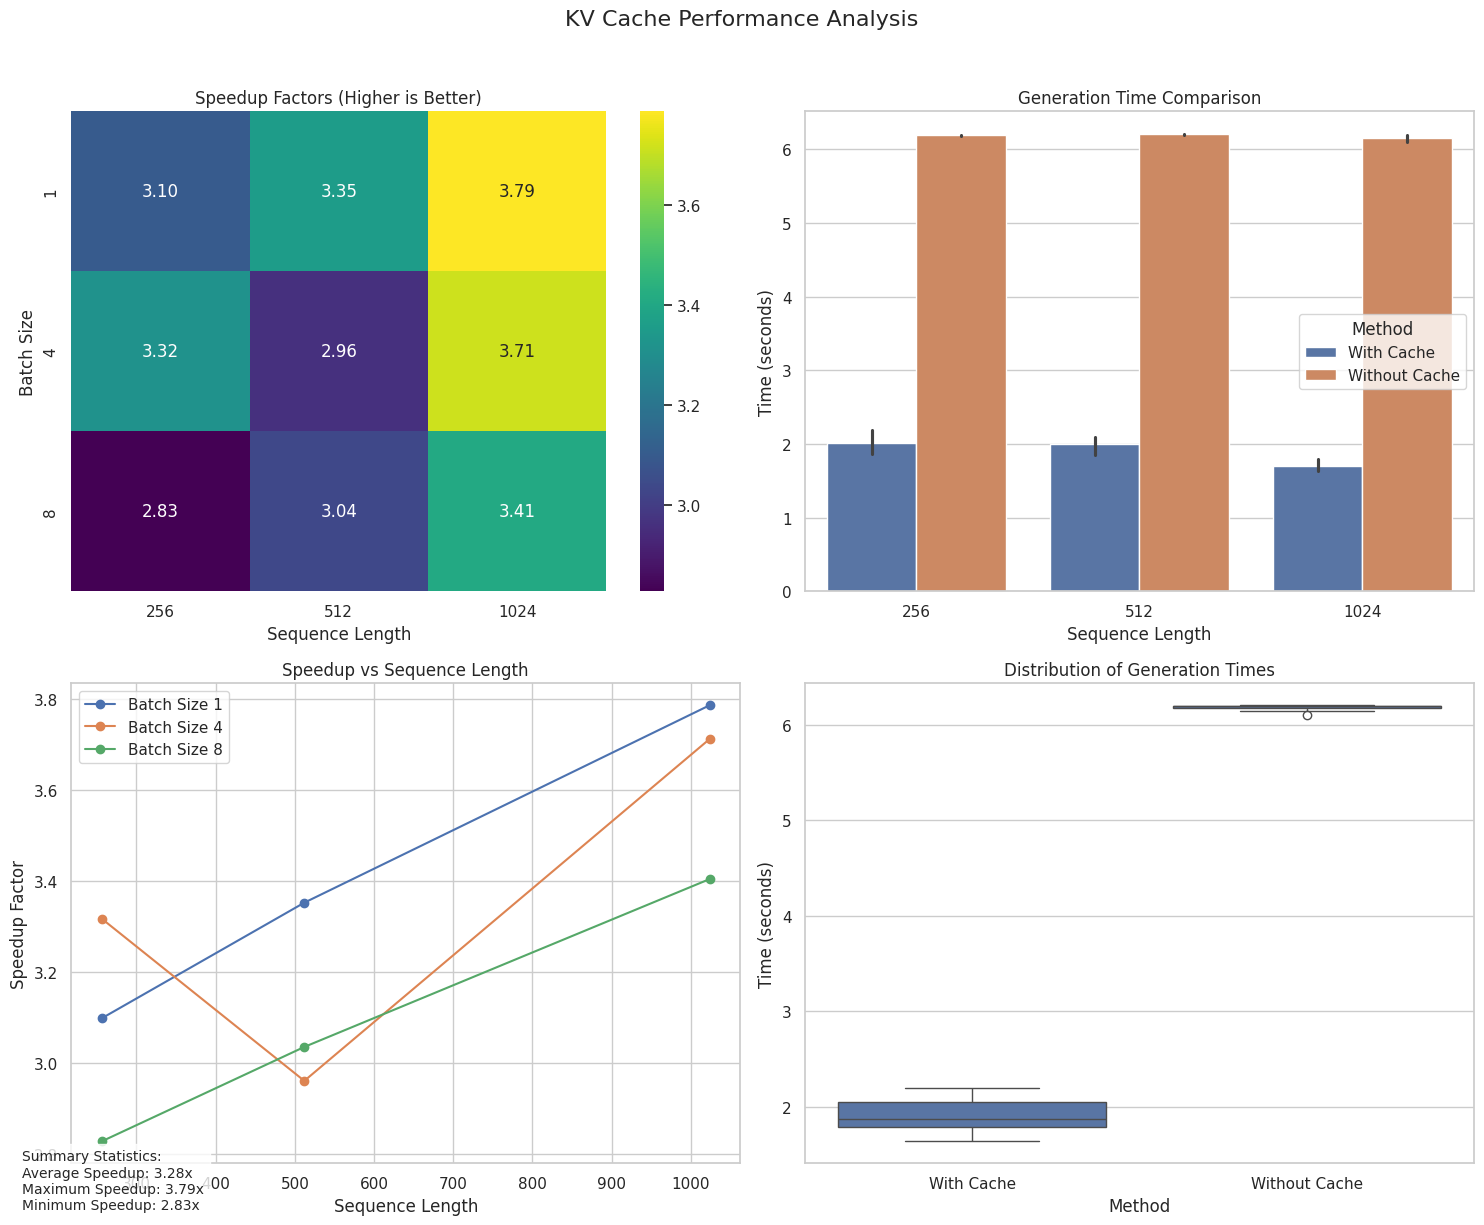

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_benchmark_results(results_data):
    """Visualize KV cache benchmark results with multiple plots"""
    # Create a list of dictionaries to hold the data for each combination of sequence length and batch size
    data = []
    for (seq_len, batch_size), metrics in results_data.items():
        data.append({
            'Sequence Length': seq_len,
            'Batch Size': batch_size,
            'With Cache': metrics['with_cache'],
            'Without Cache': metrics['without_cache'],
            'Speedup': metrics['speedup']
        })
    
    # Convert the data list to a Pandas DataFrame for easier manipulation and plotting
    df = pd.DataFrame(data)

    # Set up the plotting style using Seaborn
    sns.set_theme(style="whitegrid")
    
    # Create figure with subplots (2x2 grid of plots)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KV Cache Performance Analysis', fontsize=16, y=1.02)

    # 1. Speedup Heatmap (top left)
    # Pivot the data to create a heatmap of speedup values across batch sizes and sequence lengths
    pivot_table = df.pivot(index='Batch Size', 
                          columns='Sequence Length', 
                          values='Speedup')
    sns.heatmap(pivot_table, 
                annot=True, 
                fmt='.2f', 
                cmap='viridis',
                ax=axes[0, 0])
    axes[0, 0].set_title('Speedup Factors (Higher is Better)')

    # 2. Generation Times (top right)
    # Melt the dataframe for bar plotting of times with and without cache
    df_melted = pd.melt(df, 
                        id_vars=['Sequence Length', 'Batch Size'],
                        value_vars=['With Cache', 'Without Cache'],
                        var_name='Method', 
                        value_name='Time')
    sns.barplot(data=df_melted, 
                x='Sequence Length', 
                y='Time',
                hue='Method', 
                ax=axes[0, 1])
    axes[0, 1].set_title('Generation Time Comparison')
    axes[0, 1].set_ylabel('Time (seconds)')

    # 3. Speedup vs Sequence Length (bottom left)
    # Plot speedup vs sequence length for different batch sizes
    for batch in sorted(df['Batch Size'].unique()):
        batch_data = df[df['Batch Size'] == batch]
        axes[1, 0].plot(batch_data['Sequence Length'], 
                       batch_data['Speedup'],
                       marker='o',
                       label=f'Batch Size {batch}')
    axes[1, 0].set_title('Speedup vs Sequence Length')
    axes[1, 0].set_xlabel('Sequence Length')
    axes[1, 0].set_ylabel('Speedup Factor')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # 4. Time Distribution (bottom right)
    # Plot distribution of generation times (with vs without cache) using boxplot
    sns.boxplot(data=df_melted,
                x='Method',
                y='Time',
                ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Generation Times')
    axes[1, 1].set_ylabel('Time (seconds)')

    # Add summary statistics as text on the plot
    stats_text = (f"Summary Statistics:\n"
                 f"Average Speedup: {df['Speedup'].mean():.2f}x\n"
                 f"Maximum Speedup: {df['Speedup'].max():.2f}x\n"
                 f"Minimum Speedup: {df['Speedup'].min():.2f}x")
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8))

    # Adjust layout for better spacing and save the figure as an image
    plt.tight_layout()
    plt.savefig('kv_cache_benchmark.png', dpi=300, bbox_inches='tight')
    
    # Print summary statistics to the console
    print("\nBenchmark Summary:")
    print("-" * 50)
    print(f"Average Speedup: {df['Speedup'].mean():.2f}x")
    print(f"Maximum Speedup: {df['Speedup'].max():.2f}x")
    print(f"Minimum Speedup: {df['Speedup'].min():.2f}x")
    
    return fig

# Usage: Check if results data exists and plot the results
if 'results' in globals():
    fig = plot_benchmark_results(results)
    plt.show()


## 🎉 Congratulations, You Did It! 🎉

**Boom!** You’ve just leveled up your GPT game by optimizing its speed and performance using KV cache. Now your model can generate text faster than ever before—no more waiting around for those long response times. Your GPT is ready to go **brrrr**! 🚀💨

## 🧑‍💻 Technical Summary:

In **Notebook 6.2**, you've explored the power of **KV (Key-Value) Caching** to optimize transformer inference and drastically improve model performance during text generation.

Here's what you’ve achieved:

- **Standard Inference Review**: You began by revisiting standard inference methods from **Notebook 6.1**, where you observed how transformers slow down with longer sequences due to repeated attention computations.
  
- **KV Caching Explained**: You learned how **KV caching** works by storing previously computed attention keys and values, allowing the model to reuse them instead of recalculating for each new token. This led to substantial performance improvements.

- **Implementation of KV Cache**: Step by step, you integrated KV caching into the transformer model, ensuring it stored past keys and values while only recalculating the attention for new tokens—minimizing unnecessary recomputations.

- **Efficient Cache Management**: You gained hands-on experience slicing, updating, and retrieving cached tensors to maintain a smooth and efficient cache, which is crucial for long-running tasks.

- **Benchmarking Performance**: You measured the real-world impact of KV caching by benchmarking the **inference speeds** of models with and without the cache. The results showed impressive **speedups**, especially when processing longer sequences, confirming the effectiveness of KV caching for **real-time transformer applications**.

By now, you've mastered the KV caching technique, optimized your model, and have firsthand experience in **accelerating transformer inference**—ready for any performance-critical applications.

### 🔥 What's Next?
With KV caching in your toolkit, you're all set to scale up your transformer models for **production-level deployments**. Whether you’re looking to speed up text generation, enhance response times, or optimize for larger datasets, KV caching is the key to faster, more efficient models. 🚀


So go ahead—**make that GPT go brrrr**, create something awesome.
---
*P.S.: Never stop learning, experimenting, and having fun with deep learning. You've got this! 💪*
